# Measurement

In this chapter, you'll get to the heart of image analysis: object measurement. Using a 4D cardiac time series, you'll determine if a patient is likely to have heart disease. Along the way, you'll learn the fundamentals of image segmentation, object labeling, and morphological measurement.

## Segment the heart

In [ ]:
# Smooth intensity values
im_filt = ndi.median_filter(im, 3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

plt.imshow(mask_start)
plt.show()

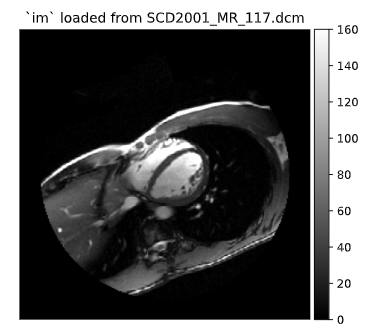

In [ ]:
# Create a `labels` overlay
overlay = np.where(labels != 0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot()

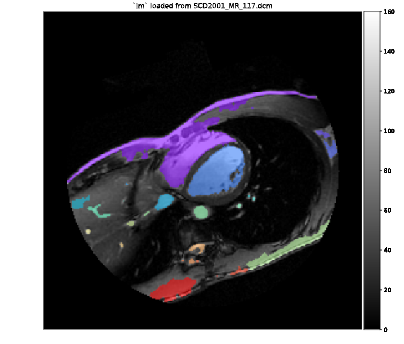

## Select objects

In [ ]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(lv_mask, cmap='rainbow')
plt.show()

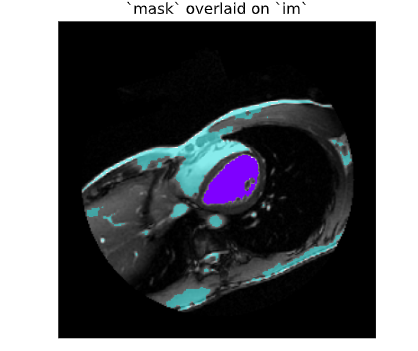

# Extract objects

In [ ]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv)
format_and_render_plot()

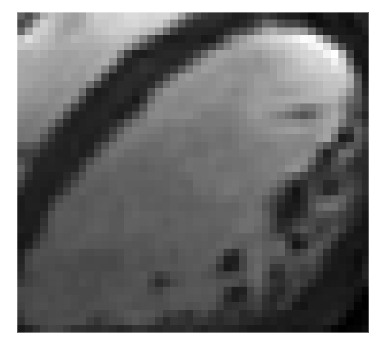

## Measure variance

In [ ]:
# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels=labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels=labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])



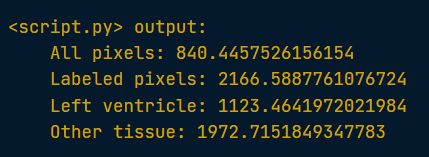

## Separate Histograms

In [ ]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()

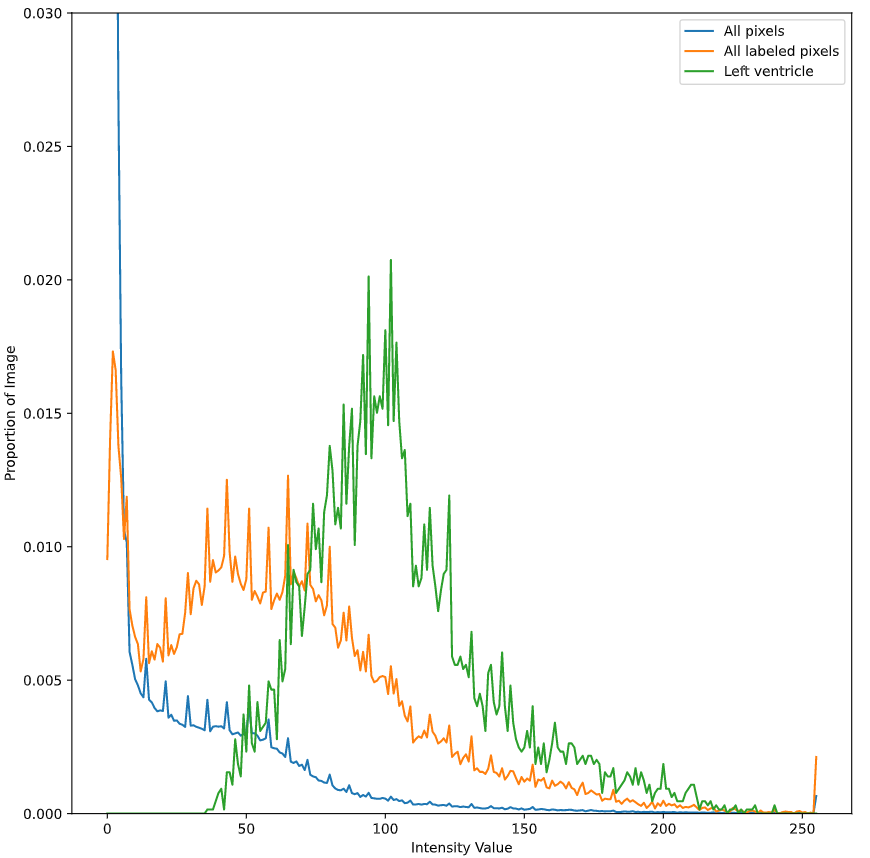

## Calculate distance

In [ ]:
# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

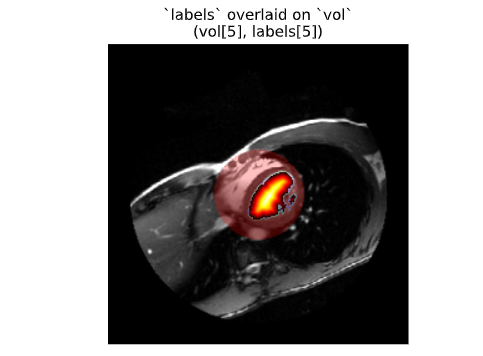

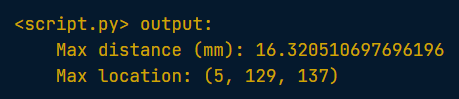

## Pinpoint center of mass

In [ ]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels=labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()

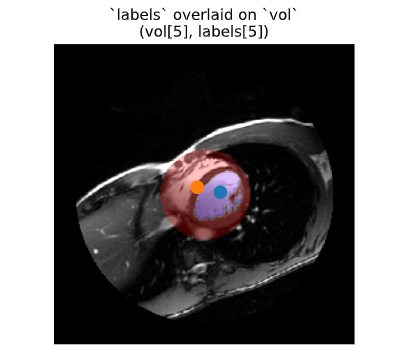

## Summarize the time series

In [ ]:
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1, d2, d3 = vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()

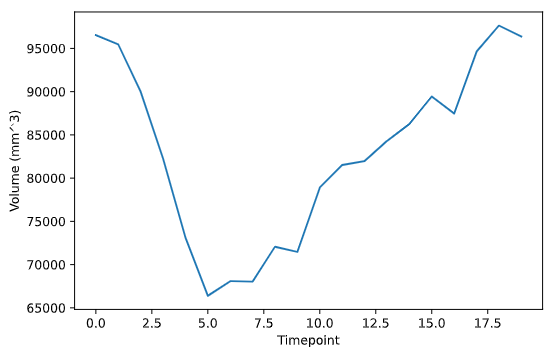

# Measure ejection fraction

In [ ]:
# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

# Plot the largest and smallest volumes
fig, axes = plt.subplots(2,1)
axes[0].imshow(vol_ts[tmax, 4], vmax=160)
axes[1].imshow(vol_ts[tmin, 4], vmax=160)
format_and_render_plots()

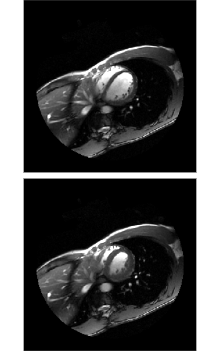

In [ ]:
# Calculate ejection fraction
ej_vol = max(ts) - min(ts)
ej_frac = ej_vol / max(ts)
print('Est. ejection volume (mm^3):', ej_vol)
print('Est. ejection fraction:', ej_frac)

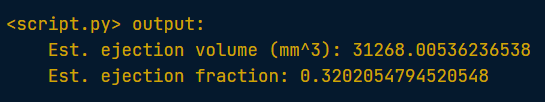